# Twitter Sentiment Analysis
#### Using Sentiment140 dataset and LSTMs


## Importing the libraries
* Tensorflow for Deep Learning
* Pandas and Numpy for handling data
* Matplotlib and Seaborn for plotting data
* Nltk to preprocess data
* Time and Tqdm for progress bar on lenghty functions.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk

import time
from tqdm.notebook import tqdm

sns.set()

## Importing the Dataset

In [3]:
# Reading the Train CSV file

raw_data = pd.read_csv("/content/drive/MyDrive/TSA/train.csv" , header = None , encoding = 'latin')

# Dropping a few useless columns

raw_data.columns = ['Y', 'A', 'B', 'C', 'D', 'X']
raw_data = raw_data.drop(['A', 'B', 'C', 'D'], axis=1)

# Mapping Positive (4) to 1 and Negative (0) to 0

raw_data['Y'] = raw_data['Y'].map({4 : 1 , 0 : 0})
raw_data['Y'].value_counts()

# Shuffling the data

raw_data = raw_data.sample(frac=1).reset_index(drop=True)

## Preprocessing Stage

In [4]:
# Declaring the function

import re

def process_text(text):

    # Lowercasing
    text = text.lower()

    # Replacing all the urls
    text = re.sub('(?i)\\b((?:https?://|www\\d{0,3}[.]|[a-z0-9.\\-]+[.][a-z]{2,4}/)(?:[^\\s()<>]+|\\(([^\\s()<>]+|(\\([^\\s()<>]+\\)))*\\))+(?:\\(([^\\s()<>]+|(\\([^\\s()<>]+\\)))*\\)|[^\\s`!()\\[\\]{};:\'\\".,<>?\xc2\xab\xc2\xbb\xe2\x80\x9c\xe2\x80\x9d\xe2\x80\x98\xe2\x80\x99]))'
               , '', text)

    # Replacing all user tags
    text = re.sub(r"@[^\s]+", '', text)

    # Replacing all hashtags
    text = re.sub(r"#[^\s]+", '', text)

    # Remove some punctuations
    text = re.sub(r"[!?,'\"*)@#%(&$_.^-]", '', text)

    # Splitting on spaces
    text = text.split(' ')

    # Stemming and removing spaces
    stemmer_ps = nltk.stem.PorterStemmer()  
    text = [stemmer_ps.stem(word) for word in text if len(word)]

    return text

In [5]:
# Modifying the data on the entire dataset
# This part takes about 7 mins

start = time.time()

raw_data['X'] = raw_data['X'].map(process_text)

end = time.time()
print(end - start)

439.7234208583832


In [6]:
# Train Test Val Split

from sklearn.model_selection import train_test_split

Train, Test = train_test_split(raw_data , stratify = raw_data["Y"], test_size=0.02)
Test, Val = train_test_split(Test , stratify = Test["Y"], test_size=0.5)

Train = Train.to_numpy()
Test = Test.to_numpy()
Val = Val.to_numpy()

del raw_data
import gc
gc.collect()

50

In [7]:
# Creating the word frequency dictionary to remove very rare words.

wordfreq = {}

start = time.time()

for _ , text in Train:
    for w in text:
        if w not in wordfreq:
            wordfreq[w] = 1
    else:
        wordfreq[w] += 1

end = time.time()
print(end - start)

7.882624626159668


In [8]:
# Getting words that have occured more than 50 times in tweets

words = [word for word in wordfreq if wordfreq[word] <= 50]
low_words = len(words)
total_words = len(wordfreq)
print(low_words , total_words - low_words , (low_words / total_words * 100) , ((total_words - low_words) / total_words * 100))

398000 2774 99.30783933089472 0.6921606691052813


In [9]:
# Removing the low occurence words from the wordfreq dictionaries

for word in words:
    if word in wordfreq: 
        del wordfreq[word]

In [10]:
# Removing the low occurence words from the tweets
# And converting them to numbers

start = time.time()

for i in range(len(Train)):
    Train[i][1] = [ word for word in Train[i][1] if word in wordfreq]

end = time.time()
print(end - start)

7.177308797836304


In [11]:
# Creating the word to number dictionary for the embedding layer

word2idx = {}

start = time.time()

for _ , text in Train:
    for w in text:
        if w not in word2idx:
            word2idx[w] = (len(word2idx) + 1)

end = time.time()
print(end - start)

6.040719747543335


### Preprocessing the Training Split

In [12]:
# Converting the tweet's words to numbers

start = time.time()

for i in range(len(Train)):
    Train[i][1] = [ word2idx[word] for word in Train[i][1] if word in word2idx]

end = time.time()
print(end - start)

7.870055198669434


In [13]:
# Creating the feature variable and padding them
X = tf.keras.preprocessing.sequence.pad_sequences(Train[ : , 1] , padding = 'post')


# Creating the target variable
Y = Train[ : , 0]

MAX_LEN = len(X[0])

### Preprocessing the Validation Split

In [14]:
# Preprocessing the Validation Split

for i in range(len(Val)):
    Val[i][1] = data = [ word2idx[word] for word in Val[i][1] if word in word2idx]

X_val = tf.keras.preprocessing.sequence.pad_sequences(Val[ : , 1] , padding = 'post' , maxlen = MAX_LEN)
Y_val = Val[ : , 0]

## Training the model

In [15]:
INPUT_DIM = len(X)
OUTPUT_DIM = 5
INPUT_LEN = len(X[0])
BATCH_SIZE = 10240

model = keras.Sequential()

model.add(layers.Embedding(input_dim=INPUT_DIM + 1 , output_dim=OUTPUT_DIM , input_length=INPUT_LEN ))
model.add(layers.LSTM(64))
model.add(layers.Dense(64 , activation = 'relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(32 , activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 5)             7840005   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                17920     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 7,864,198
Trainable params: 7,864,198
Non-trainable params: 0
______________________________________________

In [16]:
# Converting for Tensorflow Compatibility
Y = Y.astype('float64')
Y_val = Y_val.astype('float64')

# Compiling the model
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy',metrics=['accuracy'])

# Fitting the model
history = model.fit(X, Y, batch_size=BATCH_SIZE, epochs=200, validation_data = (X_val , Y_val))

Epoch 1/200
154/154 [==============================] - 24s 114ms/step - loss: 0.5902 - accuracy: 0.6493 - val_loss: 0.4711 - val_accuracy: 0.7816
Epoch 2/200
154/154 [==============================] - 17s 110ms/step - loss: 0.4690 - accuracy: 0.7830 - val_loss: 0.4641 - val_accuracy: 0.7847
Epoch 3/200
154/154 [==============================] - 17s 109ms/step - loss: 0.4619 - accuracy: 0.7846 - val_loss: 0.4558 - val_accuracy: 0.7877
Epoch 4/200
154/154 [==============================] - 17s 109ms/step - loss: 0.4567 - accuracy: 0.7859 - val_loss: 0.4501 - val_accuracy: 0.7887
Epoch 5/200
154/154 [==============================] - 17s 109ms/step - loss: 0.4524 - accuracy: 0.7870 - val_loss: 0.4484 - val_accuracy: 0.7896
Epoch 6/200
154/154 [==============================] - 17s 109ms/step - loss: 0.4503 - accuracy: 0.7877 - val_loss: 0.4475 - val_accuracy: 0.7891
Epoch 7/200
154/154 [==============================] - 17s 109ms/step - loss: 0.4475 - accuracy: 0.7892 - val_loss: 0.4554 -

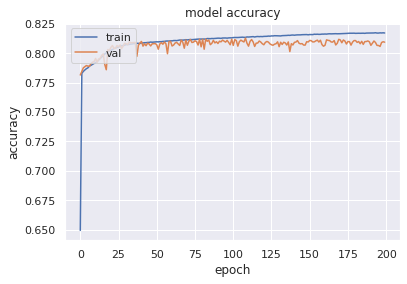

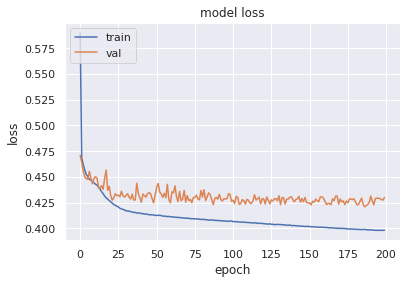

In [17]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing

In [18]:
# Preprocessing the Test Dataset

for i in range(len(Test)):
    Test[i][1] = data = [ word2idx[word] for word in Test[i][1] if word in word2idx]

# Splitting the Test set and padding the features

X_test = tf.keras.preprocessing.sequence.pad_sequences(Test[ : , 1] , padding = 'post' , maxlen = MAX_LEN)
Y_test = Test[ : , 0]

In [26]:
# Predicting
Y_pred = model.predict(X_test)

Y_pred = np.where(Y_pred > 0.5, 1, 0)
Y_test = list(Y_test)

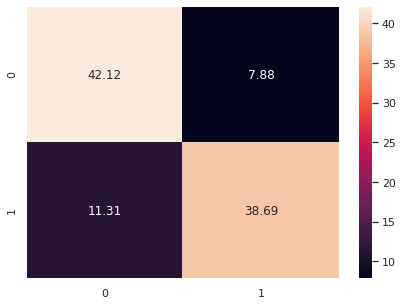

In [28]:
# Plotting the Confusion Matrix
from sklearn.metrics import confusion_matrix
df_cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize = (7,5))
sns.heatmap(df_cm / len(Y_test) * 100, fmt = '.2f', annot=True)

In [29]:
# Metrics related to the classification
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      8000
           1       0.83      0.77      0.80      8000

    accuracy                           0.81     16000
   macro avg       0.81      0.81      0.81     16000
weighted avg       0.81      0.81      0.81     16000

